In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pickle
from IPython.core.display import display, HTML
import pandas as pd

import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Dropout
from keras.models import Model
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('spectrograms_segmented_concatenated.obj', 'rb') as specgram_file:
    specgrams = pickle.load(specgram_file)

print('Number of spectrograms: %s' % len(specgrams))

Number of spectrograms: 77


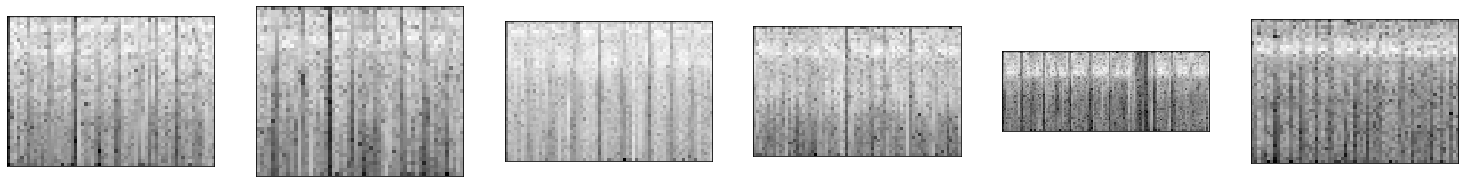

In [4]:
n=6
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(specgrams[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [5]:
def max_multiple(number, base=4):
    return base * int(number/base)

In [6]:
min_x, min_y = min(specgram.shape[1] for specgram in specgrams), specgrams[0].shape[0]
min_x_mult, min_y_mult, min_x_50 = max_multiple(min_x), max_multiple(min_x), int(1.5*min_x)
print(min_x, min_y)
print(min_x_mult, min_y_mult, min_x_50)

45 45
44 44 67


In [7]:
# Reshape spectrograms by limiting number of columns to a max
reshape = []
for specgram in specgrams:
    reshape.append(specgram[:min_y_mult, :min_x_mult])
    if specgram.shape[1] > min_x_50:
        reshape.append(specgram[:min_y_mult, -min_x_mult:])  # if columns is > 1.5*min_size, append the last min_size columns

#Flip
augment = []
for specgram in reshape:
    augment.append(specgram)
    augment.append(np.flip(specgram, 0))  # flip rows / y axis
    augment.append(np.flip(specgram, 1))  # flip columns / x axis
    augment.append(np.flip(specgram, (0, 1)))  # flip rows and columns / x and y axis

print(len(augment))

400


In [8]:
# Obtain 3 dimensional shape
dim = augment[0].shape
if len(dim) < 3:
    dim += (1,)
print(dim)

(44, 44, 1)


In [9]:
# Split dataset between train and test
X_train, X_test = train_test_split(augment, test_size=0.25, shuffle=False)
print('Training samples: ' + str(len(X_train)))
print('Test samples: ' + str(len(X_test)))

Training samples: 300
Test samples: 100


In [10]:
# Add gaussian noise
noise_factor = 0.1

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

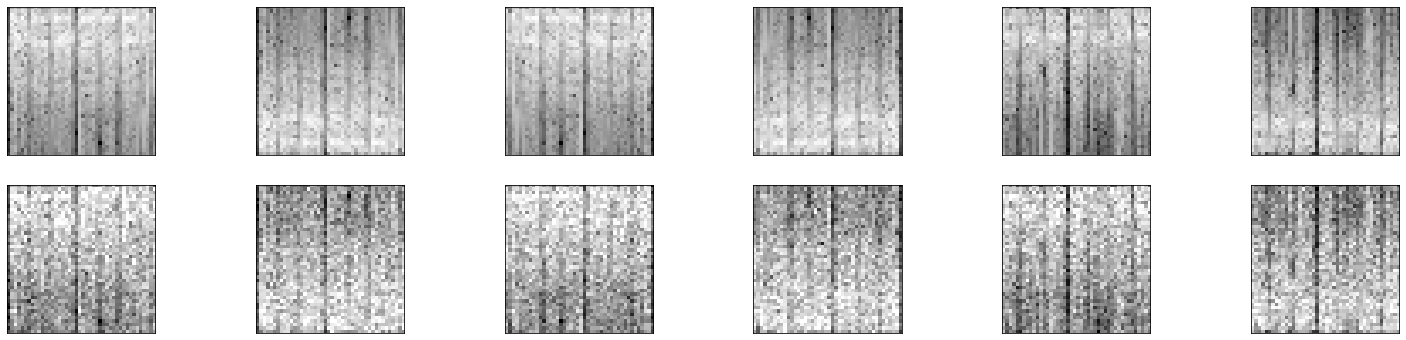

In [11]:
# Visualize original x noisy
n=6
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    ax.imshow(X_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i+n+1)
    ax.imshow(X_train_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [12]:
# Reshape images to be 3 dimensional
X_train = np.reshape(X_train, (len(X_train), dim[0], dim[1], dim[2]))
X_test = np.reshape(X_test, (len(X_test), dim[0], dim[1], dim[2]))

X_train_noisy = np.reshape(X_train_noisy, (len(X_train_noisy), dim[0], dim[1], dim[2]))
X_test_noisy = np.reshape(X_test_noisy, (len(X_test_noisy), dim[0], dim[1], dim[2]))

## Autoencoder Model

In [13]:
input_img = Input(shape=dim)
n_features = 128

# encoder
## conv.layers
code = Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(4, kernel_size=(3, 3), padding='same', activation='relu')(code)
# code = Conv2D(4, kernel_size=(5, 6), padding='valid', activation='relu')(code)

## dense.layers
# code = Flatten()(code)
# code = Dropout(0.25)(code)
# code = Dense(n_features * 64, activation='relu')(code)
# code = Dense(n_features * 16, activation='relu')(code)
# code = Dense(n_features * 4, activation='relu')(code)
# bottleneck = Dense(n_features, activation='relu')(code)  # bottleneck

# decoder
## dense.layers
# x_hat = Dense(n_features * 4, activation='relu')(bottleneck)
# x_hat = Dense(n_features * 16, activation='relu')(x_hat)
# x_hat = Dense(n_features * 64, activation='relu')(x_hat)
# x_hat = Dense(2176, activation='relu')(code)

## conv.layers
# x_hat = Reshape((5, 5, 4))(code)
x_hat = Conv2DTranspose(8, kernel_size=(3, 3), padding='same', activation='relu')(code)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(16, kernel_size=(3, 3), padding='same', activation='relu')(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(1, kernel_size=(5, 5), padding='same', activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44, 44, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 4)         292       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 11, 11, 8)         296       
__________

In [14]:
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')
# autoencoder.compile(loss='mse', optimizer='adam')

# tamanho do batch por iteracao
batch_size = 25

# número de épocas 
epochs = 50

# a variável history guarda os dados do processo de treinamento para
# posteriormente analisarmos
history = autoencoder.fit([X_train_noisy], [X_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=([X_test_noisy], [X_test]))

Train on 300 samples, validate on 100 samples
Epoch 1/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0198
Epoch 2/50
300/300 [==============================] - 0s 1ms/step - loss: 0.0197 - val_loss: 0.0203
Epoch 3/50
300/300 [==============================] - 0s 1ms/step - loss: 0.0189 - val_loss: 0.0185
Epoch 4/50
300/300 [==============================] - 0s 1ms/step - loss: 0.0183 - val_loss: 0.0179
Epoch 5/50
300/300 [==============================] - 0s 1ms/step - loss: 0.0181 - val_loss: 0.0187
Epoch 6/50
300/300 [==============================] - 0s 2ms/step - loss: 0.0179 - val_loss: 0.0182
Epoch 7/50
300/300 [==============================] - 0s 1ms/step - loss: 0.0178 - val_loss: 0.0173
Epoch 8/50
300/300 [==============================] - 0s 1ms/step - loss: 0.0168 - val_loss: 0.0164
Epoch 9/50
300/300 [==============================] - 0s 1ms/step - loss: 0.0172 - val_loss: 0.0169
Epoch 10/50
300/300 [==============================] -

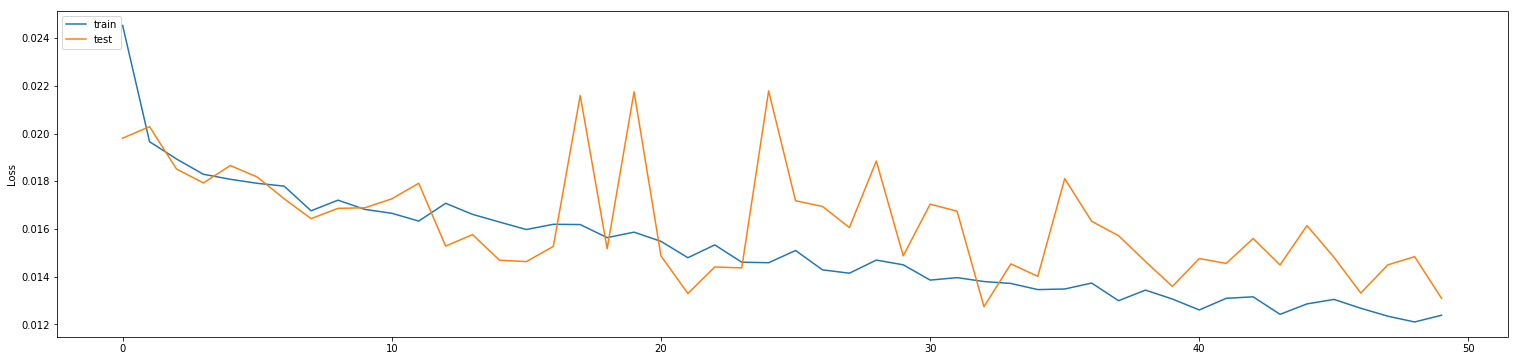

In [15]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

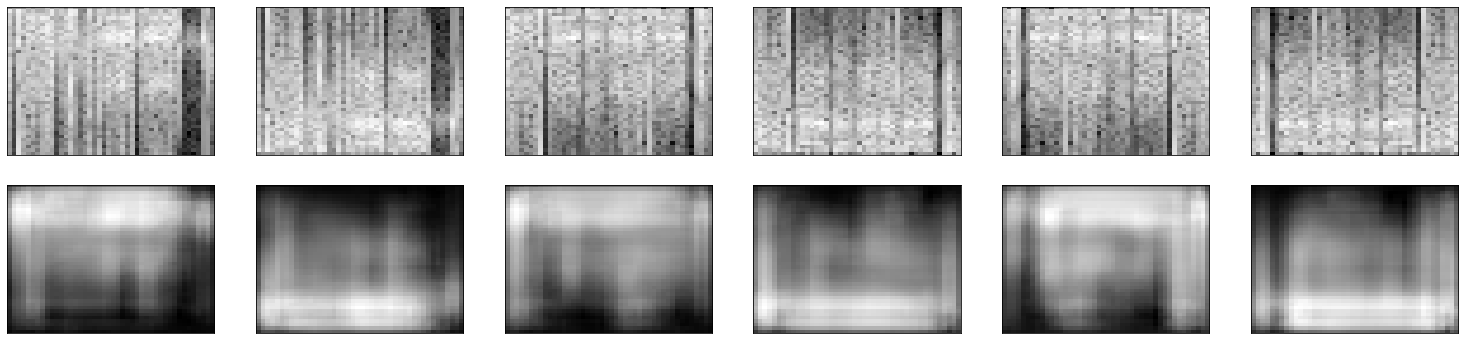

In [16]:
decoded_test = np.reshape(X_test, (len(X_test), dim[0], dim[1]))
decoded_predictions = autoencoder.predict([X_test])
decoded_predictions = np.reshape(decoded_predictions, (len(decoded_predictions), dim[0], dim[1]))

start, stop = 10, 16
for i, n in enumerate(range(start, stop), start=1):
    ax = plt.subplot(2, stop-start, i)
    plt.imshow(decoded_test[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, stop-start, i+stop-start)
    plt.imshow(decoded_predictions[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Utilizando o bottleneck para extracação de features

In [17]:
encoder = Model(input_img, bottleneck)
encoder.summary()

NameError: name 'bottleneck' is not defined

In [ ]:
features = encoder.predict([X_test])
df = pd.DataFrame(features)

In [ ]:
df.describe()

In [ ]:
df

### From here onwards a label and predicted label was added randomly for testing ROC curve and AUC percentage

In [ ]:
df = df.assign(Label=np.random.randint(2, size=len(df)))
df = df.assign(Predicted=np.random.random_sample(size=len(df)))
df.head(10)

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(df['Label'].values, df['Predicted'].values)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('Area Underneath Curve percentage (AUC):', metrics.roc_auc_score(df['Label'].values, df['Predicted'].values))

In [ ]:
data = {'Threshold':thresholds, 'True Positive':tpr, 'False Positive':fpr}
df2 = pd.DataFrame(data)
df2

In [ ]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

evaluate_threshold(0.2)
evaluate_threshold(0.5)
evaluate_threshold(0.7)